In [1]:
import os
from utils import load_mvtec_dataset
from keras.preprocessing.image import image
import matplotlib.pyplot as plt
import numpy as np
main_dir = 'mvtec_anomaly_detection_data_umsortiert'


In [2]:
train_images, train_labels, test_images, test_labels, ground_truth_paths = load_mvtec_dataset(main_dir, 'bottle', 224)
train_images.shape

(243, 224, 224, 3)

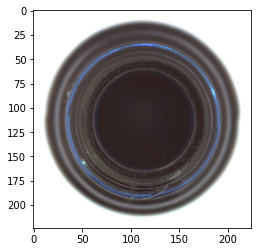

In [3]:
plt.imshow(train_images[1])

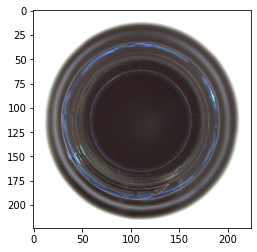

In [4]:
train_img=train_images/255.0
test_img=test_images/255.0

plt.imshow(test_img[0])

In [5]:
from keras import layers
from keras.models import Model, Sequential
from keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from keras.layers import Dense, Flatten

In [6]:
resnet50 = ResNet50V2(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
# don't train existing weights
for layer in resnet50.layers:
    layer.trainable = False
x = Flatten()(resnet50.output)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=resnet50.input, outputs=prediction)


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'accuracy', patience = 2)
train_img.shape
#train_img=np.expand_dims(train_img,axis=0)
#train_img.shape


(243, 224, 224, 3)

In [9]:
# Model
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

history = model.fit(
  train_img, 
  train_labels,
  epochs=25,
  batch_size=32,shuffle=True,
  callbacks=cb_early_stopper)

Epoch 1/25
8/8 [==============================] - 24s 2s/step - loss: 8.8613 - accuracy: 0.7695
Epoch 2/25
8/8 [==============================] - 21s 3s/step - loss: 1.4016 - accuracy: 0.8560
Epoch 3/25
8/8 [==============================] - 21s 3s/step - loss: 0.3918 - accuracy: 0.9753
Epoch 4/25
8/8 [==============================] - 22s 3s/step - loss: 0.4249 - accuracy: 0.9671
Epoch 5/25
8/8 [==============================] - 22s 3s/step - loss: 4.2715e-04 - accuracy: 1.0000
Epoch 6/25
8/8 [==============================] - 21s 3s/step - loss: 0.1361 - accuracy: 0.9877
Epoch 7/25
8/8 [==============================] - 21s 3s/step - loss: 0.0629 - accuracy: 0.9918


INFO:tensorflow:Assets written to: Model/Transfer\assets


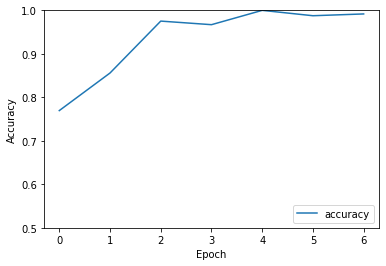

In [10]:
model.save('Model/Transfer')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

2/2 - 10s - loss: 1.5067 - accuracy: 0.9184 - 10s/epoch - 5s/step


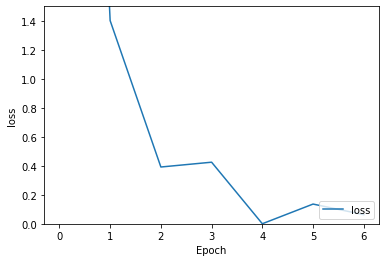

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.5])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_img, test_labels, verbose=2)

(224, 224, 3)

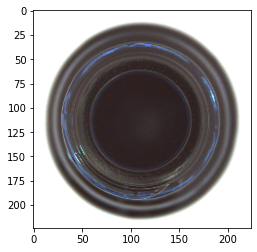

In [12]:
plt.imshow(test_images[0])
test_images[0].shape

In [16]:
test_labels
pred = model.predict_generator(test_img, steps = len(test_img), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)

C:\Users\tobia\AppData\Local\Temp\ipykernel_8164\464997578.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_img, steps = len(test_img), verbose = 1)


49/49 [==============================] - 8s 142ms/step


In [17]:
len(pred)
predicted_class_indices

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0], dtype=int64)

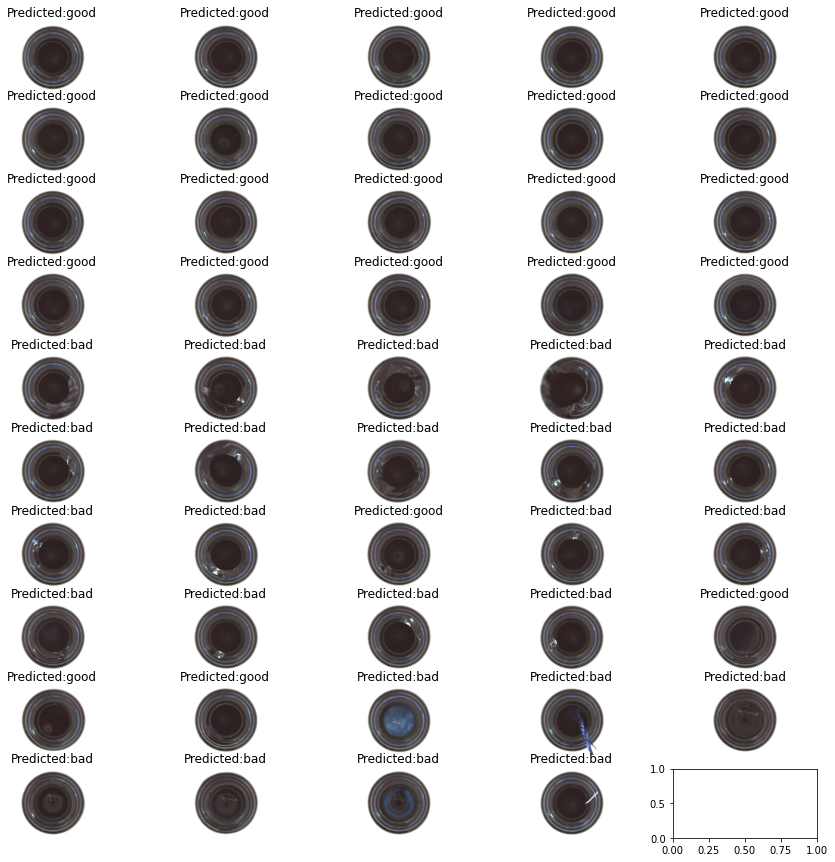

In [18]:
import cv2
f, ax = plt.subplots(10, 5, figsize = (15, 15))

for i in range(len(test_img)):
    img = test_img[i]
    #imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "good" if predicted_class_indices[i] else "bad"

    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))  